# INFNET Robust Iris

## V3

In [85]:
import numpy
import pandas
import tensorflow
import keras
from matplotlib import pyplot
import seaborn
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import itertools

%matplotlib inline

In [86]:
# CLASSIFIER PARAMETERS
my_vars = ['petallength', 'petalwidth'] # 'sepallength', 'sepalwidth', 'petallength', 'petalwidth'
class_col = 'flower'
my_class = 'Iris-versicolor' # 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica'

# TRAINING PARAMETERS
max_hidden_neurons = 4
hidden_neuron_activation = 'sigmoid'
my_metric = 'Precision' # 'Precision', 'Recall'
my_patience = 100
max_epoch = 20*my_patience
rmsprop_lr = 0.01
adam_initial_lr = 0.01
adam_decay_steps = max_epoch
adam_lr_decay = 0.99

# EARLY STOPPING PARAMETERS
hyperparameter_early_stopping = True
rollback_capacity = True
min_improvement = 0.01
min_neuron_gain = 0.01
min_median_gain = 0.01

# CONTROL RANDOMNESS
random_seed = 33
n_k_folds = 5

c:\Users\User\miniconda3\envs\infnet-nn\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


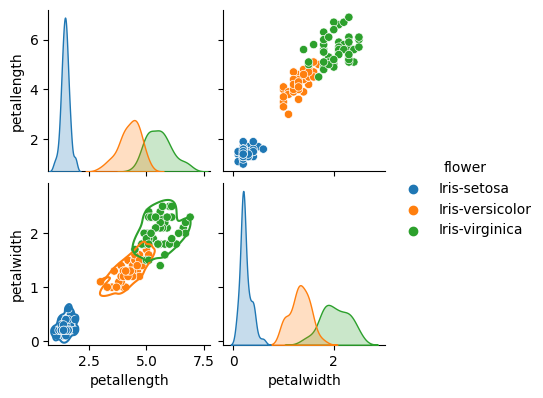

In [87]:
# SELECTION FROM IRIS DATAFRAME
my_vars_w_class = my_vars.copy()
my_vars_w_class.append(class_col)
iris = pandas.read_csv('iris.data')
iris = iris[my_vars_w_class]

# SCATTER PLOT
_ = g = seaborn.pairplot(iris, hue='flower', height=2, diag_kind='kde')
_ = g.map_lower(seaborn.kdeplot, levels=1, color=".2")

## Robust Training Procedure

In [88]:
# CHECK IF CLASS IS CORRECTLY ASSIGNED
if my_class not in ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']:
    print(f'Classe {my_class} não encontrada! Digite uma das seguintes classes: Iris-setosa, Iris-versicolor, Iris-virginica')

In [89]:
# SET THE RANDOM SEED
numpy.random.seed(random_seed)
tensorflow.random.set_seed(random_seed)

In [90]:
# BUILD OUR CUSTOM K FOLD BOXES, STRATIFIEDKFOLD SUCKS
boxes = [] # list of indexes of the samples in each box
sampled_ids = []
n_positives = iris.loc[iris['flower'] == my_class, :].shape[0]
n_negatives = iris.loc[iris['flower'] != my_class, :].shape[0]
for i in range(0, n_k_folds):
    my_class_ix = (iris['flower'] == my_class)
    not_sampled_ix = (~iris.index.isin(sampled_ids))
    positive_sample_ix_list = iris.loc[my_class_ix & not_sampled_ix, :].sample(n=int(n_positives/n_k_folds), random_state=random_seed, replace=False).index.to_list()
    negative_sample_ix_list = iris.loc[~my_class_ix & not_sampled_ix, :].sample(n=int(n_negatives/n_k_folds), random_state=random_seed, replace=False).index.to_list()
    boxes.append(positive_sample_ix_list + negative_sample_ix_list)
    sampled_ids += positive_sample_ix_list + negative_sample_ix_list

In [91]:
# INITIALIZE OPTIMIZERS
 
# OPTIMIZERS TO COMPARE
adam_lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(adam_initial_lr,
                                                                          adam_decay_steps,
                                                                          adam_lr_decay)

optimizers = {'adam': tensorflow.keras.optimizers.legacy.Adam(learning_rate=adam_lr_schedule),
              'rmsprop': tensorflow.keras.optimizers.legacy.RMSprop(learning_rate=rmsprop_lr)}

In [92]:
# PREPARE DATA
X_df = iris[my_vars].copy()
Y_series = (iris['flower'] == my_class).astype(int)

In [93]:
# PRODUCE NORMALIZER
X_scaler = StandardScaler()
X_scaler = X_scaler.fit(X_df.to_numpy())

In [94]:
# TRAINING LOOP
# FOR EACH OPTIMIZER
best_net_name = None
best_net = None
best_training_metric = 0.0
best_validation_metric = 0.0
best_test_metric = 0.0
box_lower_bound = 0.0
box_median = 0.0
result_list = []

# Produce validation / test folds
fold_permutations = list(itertools.permutations(range(0, n_k_folds), 2))

should_break = False
# START NEURON LOOP
print('TRAINING PROCEDURE STARTED...\n')
for n_neuron in numpy.arange(1, max_hidden_neurons+1):
    for optimizer in optimizers:
        for validation_id, test_id in fold_permutations:
            net_name = f'{my_class.upper()}_{optimizer.upper()}_{n_neuron}_V{validation_id}T{test_id}'
            
            # CREATE IRISER
            inputs = keras.Input(shape=(len(my_vars), ))
            hidden = keras.layers.Dense(n_neuron, activation=hidden_neuron_activation)(inputs)
            outputs = keras.layers.Dense(1, activation='sigmoid')(hidden)
            neural_network = keras.Model(inputs=inputs, outputs=outputs, name=net_name)

            # COMPILE NET
            training_metric_name = f'{my_metric.lower()}'
            validation_metric_name = f'val_{my_metric.lower()}'
            test_metric_name = f'test_{my_metric.lower()}'

            neural_network.compile(optimizer=optimizers[optimizer], loss='mse', metrics=[my_metric])
            es_loss = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=my_patience, restore_best_weights=True)
            training_es_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=training_metric_name, mode='max', patience=my_patience, min_delta=min_improvement)
            validation_es_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=validation_metric_name, mode='max', patience=n_k_folds*my_patience, min_delta=min_improvement)

            # GET X AND Y
            validation_ids = boxes[validation_id]
            test_ids = boxes[test_id]
            train_ids = [x for x in X_df.index if x not in validation_ids and x not in test_ids]

            X_train = X_scaler.transform(X_df.loc[train_ids, my_vars].to_numpy())
            Y_train = Y_series.loc[train_ids].to_numpy()[:, numpy.newaxis]

            X_val = X_scaler.transform(X_df.loc[validation_ids, my_vars].to_numpy())
            Y_val = Y_series.loc[validation_ids].to_numpy()[:, numpy.newaxis]

            X_test = X_scaler.transform(X_df.loc[test_ids, my_vars].to_numpy())
            Y_test = Y_series.loc[test_ids].to_numpy()[:, numpy.newaxis]

            # FIT W CLASS WEIGHTS
            my_class_weight = Y_train.shape[0]/Y_train.sum()
            other_class_weight = Y_train.shape[0]/(Y_train==0).sum()
            class_weights = {0: other_class_weight, 1: my_class_weight}
            history = neural_network.fit(X_train,
                                         Y_train,
                                         validation_data=(X_val, Y_val),
                                         batch_size=X_train.shape[0],
                                         epochs=max_epoch,
                                         verbose=0,
                                         callbacks=[es_loss, training_es_metric, validation_es_metric],
                                         class_weight=class_weights)

            # TRAINING RESULTS
            training_loss = history.history['loss'][-1]
            validation_loss = history.history['val_loss'][-1]
            training_metric = history.history[training_metric_name][-1]
            validation_metric = history.history[validation_metric_name][-1]
            n_epochs = len(history.history['val_loss'])
            test_loss, test_metric = neural_network.evaluate(X_test, Y_test, verbose=0)

            best_net_txt = ''
            best_net_end = '\r'
            is_best = False
            if hyperparameter_early_stopping:
                # CHECK IF BEST NET
                equal_or_best = training_metric >= best_training_metric and validation_metric >= best_validation_metric and test_metric >= best_training_metric
                training_improved = training_metric > best_training_metric + min_improvement
                validation_improved = validation_metric > best_validation_metric + min_improvement
                test_improved = test_metric > best_test_metric + min_improvement
                is_best = equal_or_best and (training_improved or validation_improved or test_improved)

                if is_best:
                    best_net_name = net_name
                    best_optimizer = optimizer
                    best_net = neural_network
                    best_neurons = n_neuron
                    best_training_metric = training_metric
                    best_validation_metric = validation_metric
                    best_test_metric = test_metric
                    best_net_txt = '**Best NET!**'
                    best_net_end = '\n'
                    is_best = True

            result_dict = {'net_name': net_name,
                           'optimizer': optimizer,
                           'neurons': n_neuron,
                           'validation_id': validation_id,
                           'test_id' : test_id,
                           'epochs' : n_epochs,
                           'training_loss': training_loss,
                           'validation_loss' : validation_loss,
                           'test_loss' : test_loss,
                           training_metric_name : training_metric,
                           validation_metric_name : validation_metric,
                           test_metric_name : test_metric,
                           'neural_network': neural_network,
                           'history' : history,
                           'is_best' : is_best}

            result_list.append(result_dict)
            print(f'{net_name} | {n_epochs} epochs | {my_metric} {100.0*training_metric:.0f}/{100.0*validation_metric:.0f}/{100.0*test_metric:.0f}% | Loss {test_loss:.2f}/{validation_loss:.2f}/{training_loss:.2f} train/val/test {best_net_txt}', end=best_net_end)

            should_break = hyperparameter_early_stopping and training_metric == 1.0 and validation_metric == 1.0 and test_metric == 1.0
            # EARLY STOPPING TRIGGERS
            if should_break:
                print(f'\nProblem Solved with {net_name}!')
                break
        if should_break:
            break
    if should_break:
        break

    need_extra_neurons = True
    box_improve = False
    if hyperparameter_early_stopping:
        # TEST IF MORE NEURONS ARE NECESSARY

        if n_neuron > 1:
            
            # INCREASING NEURONS DIDNT ACHIEVE BEST NET
            if best_neurons < n_neuron:
                need_extra_neurons = False
                print('\nNETs w {} neurons didnt improve {}!'.format(n_neuron, training_metric_name))
                break

        # GET LOWER BOUND OF WINNING ALGORITHM
        partial_results = pandas.DataFrame(result_list)
        lower_bound_est = partial_results[(partial_results.optimizer == best_optimizer) & (partial_results.neurons == n_neuron)][validation_metric_name].min()
        median_est = partial_results[(partial_results.optimizer == best_optimizer) & (partial_results.neurons == n_neuron)][validation_metric_name].median()

        if not need_extra_neurons:
            print('\ndont need extra neurons!')
            break

        # TEST IF LOWER BOUND IMPROVED AND MEDIAN IMPROVED

        if n_neuron > 1:
            neuron_gain = 0.0
            median_gain = 0.0
            if lower_bound_est > box_lower_bound or median_est > box_median: # IMPROVED
                if box_lower_bound > 0.0 and box_median > 0.0: # NOT FIRST ITERATION > CALCULATE GAIN
                    neuron_gain = lower_bound_est/box_lower_bound - 1.0
                    median_gain = median_est/box_median - 1.0
                    if neuron_gain <= min_neuron_gain and median_gain <= min_median_gain:
                        box_improve = False
                        print(f'\nNETs w {n_neuron} neurons didnt improve min {validation_metric_name} {100.0*lower_bound_est:.1f} neuron gain {100.0*neuron_gain:.1f} / min {100.0*min_neuron_gain:.1f} or median gain {100.0*median_gain:.1f} / min {100.0*min_median_gain:.1f}!')
                        break
                    else:
                        box_improve = True
                        print(f'\nNETs Neuron Gain w/ {n_neuron} neurons: {100.0*box_lower_bound:.1f} >> {100.0*lower_bound_est:.1f} = {100.0*neuron_gain:.2f}% | Median Gain w/ {n_neuron} neurons: {100.0*box_median:.1f} >> {100.0*median_est:.1f} = {100.0*median_gain:.2f}%')
                else: # FIRST ITERATION
                    box_improve = True
                    print(f'\nNET Neural Gain From 0.0 >> {100.0*lower_bound_est:.1f}% and Median Gain From 0.0 >> {100.0*median_est:.1f}%')
            else:
                print(f'\nNo Lower Bound Gain on {n_neuron} neurons for {best_optimizer}: {100.0*box_lower_bound:.1f} >> {100.0*lower_bound_est:.1f} or no Median Gain on {n_neuron} neurons for {best_optimizer}: {100.0*box_median:.1f} >> {100.0*median_est:.1f}')
                box_improve = False
                break
        else:
            box_improve = True
            print(f'\nNET Lower Bound Estimation for {n_neuron} neuron @ {optimizer}: {100.0*lower_bound_est:.1f}% | Median {100.0*median_est:.1f}%')
        
        box_lower_bound = lower_bound_est
        box_median = median_est
        print('')

    if hyperparameter_early_stopping and (not need_extra_neurons or not box_improve):
        print(f'\nDont need extra neurons {need_extra_neurons} or box didnt improve {box_improve}')
        break

TRAINING PROCEDURE STARTED...

IRIS-VERSICOLOR_ADAM_1_V0T1 | 119 epochs | Precision 53/42/53% | Loss 0.22/0.27/0.42 train/val/test **Best NET!**
IRIS-VERSICOLOR_ADAM_1_V4T2 | 150 epochs | Precision 65/67/57% | Loss 0.23/0.19/0.36 train/val/test **Best NET!**
IRIS-VERSICOLOR_RMSPROP_1_V4T3 | 226 epochs | Precision 49/62/41% | Loss 0.25/0.14/0.37 train/val/test 
NET Lower Bound Estimation for 1 neuron @ rmsprop: 37.5% | Median 52.6%

IRIS-VERSICOLOR_ADAM_2_V1T2 | 139 epochs | Precision 94/100/83% | Loss 0.07/0.02/0.07 train/val/test **Best NET!**
IRIS-VERSICOLOR_RMSPROP_2_V4T3 | 265 epochs | Precision 91/90/100% | Loss 0.07/0.08/0.15 train/val/test 
NETs Neuron Gain w/ 2 neurons: 37.5 >> 41.7 = 11.11% | Median Gain w/ 2 neurons: 52.6 >> 55.6 = 5.56%

IRIS-VERSICOLOR_RMSPROP_3_V4T3 | 380 epochs | Precision 94/90/100% | Loss 0.03/0.06/0.07 train/val/test 
NETs w 3 neurons didnt improve precision!


In [95]:
df_results = pandas.DataFrame(result_list)
capacity = df_results.neurons.max() - int(rollback_capacity)*int(hyperparameter_early_stopping)*int(not need_extra_neurons)
best_results = df_results.loc[df_results['neurons'] <= capacity, :].copy()
columns_to_sort = [test_metric_name, validation_metric_name, training_metric_name, 'neurons']
ascending = [False, False, False, True]
best_results.sort_values(by=columns_to_sort, ascending=ascending).head(5)

,net_name,optimizer,neurons,validation_id,test_id,epochs,training_loss,validation_loss,test_loss,precision,val_precision,test_precision,neural_network,history,is_best
53,IRIS-VERSICOLOR_ADAM_2_V3T1,adam,2,3,1,201,0.095915,0.019991,0.017844,0.852941,1.0,1.0,<keras.src.engine.functional.Functional object...,<keras.src.callbacks.History object at 0x00000...,False
77,IRIS-VERSICOLOR_RMSPROP_2_V4T1,rmsprop,2,4,1,321,0.107941,0.060837,0.043672,0.935484,0.9,1.0,<keras.src.engine.functional.Functional object...,<keras.src.callbacks.History object at 0x00000...,False
57,IRIS-VERSICOLOR_ADAM_2_V4T1,adam,2,4,1,151,0.066642,0.048705,0.024209,0.906250,0.9,1.0,<keras.src.engine.functional.Functional object...,<keras.src.callbacks.History object at 0x00000...,False
59,IRIS-VERSICOLOR_ADAM_2_V4T3,adam,2,4,3,180,0.064855,0.045274,0.018468,0.906250,0.9,1.0,<keras.src.engine.functional.Functional object...,<keras.src.callbacks.History object at 0x00000...,False
79,IRIS-VERSICOLOR_RMSPROP_2_V4T3,rmsprop,2,4,3,265,0.145067,0.077425,0.069523,0.906250,0.9,1.0,<keras.src.engine.functional.Functional object...,<keras.src.callbacks.History object at 0x00000...,False


In [96]:
best_row = best_results.sort_values(by=columns_to_sort, ascending=ascending).head(1)
best_net_name = best_row['net_name'].values[0]
best_optimizer = best_row['optimizer'].values[0]
best_net = best_row['neural_network'].values[0]
best_neurons = best_row['neurons'].values[0]
best_training_metric = best_row[training_metric_name].values[0]
best_validation_metric = best_row[validation_metric_name].values[0]
best_test_metric = best_row[test_metric_name].values[0]
best_epochs = best_row['epochs'].values[0]
best_history = best_row['history'].values[0]

In [97]:
# CLASS COLOR GRID & CLASS EVALUATION
grid_n_points = 100
class_threshold = 0.5
little_delta = 0.1
jitter_factor = 0.1
rect_expansion = 1.1

# X0 W JITTER
X = X_df.to_numpy()
X_scaled = X_scaler.transform(X)
Y = Y_series.to_numpy()[:, numpy.newaxis]
x0_grid = numpy.linspace(0, rect_expansion*(X[:, 0].max()), grid_n_points)
x0_jitter = jitter_factor*(x0_grid[1] - x0_grid[0])
x1_grid = numpy.linspace(0, rect_expansion*(X[:, 1].max()), grid_n_points)
x1_jitter = jitter_factor*(x1_grid[1] - x1_grid[0])
X_g = numpy.array(list(itertools.product(x0_grid, x1_grid)))
X_g[:, 0] += x0_jitter*numpy.random.randn(X_g.shape[0])
X_g[:, 1] += x1_jitter*numpy.random.randn(X_g.shape[0])
X_g_scaled = X_scaler.transform(X_g)
Y_g = best_net.predict(X_g_scaled, verbose=0)
Y_est = (best_net.predict(X_scaled, verbose=0) > class_threshold).astype(int)
t_error, t_statistic = best_net.evaluate(X_scaled, Y, verbose=0)

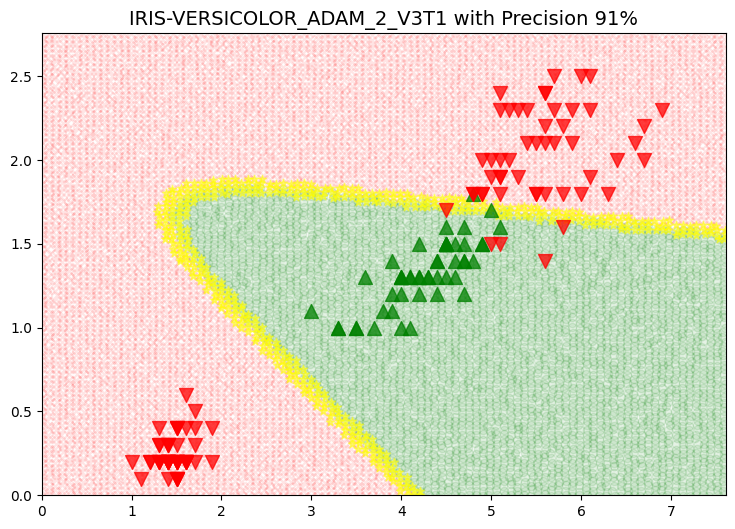

In [98]:
# CLASSIFICATION FIGURE
height = 6
fig = pyplot.figure(figsize=(height/0.68, height))
ax = fig.add_subplot(111)
# PLOT CLASS REGION
ix_class_region = Y_g.reshape(-1) > class_threshold
ix_class_points = Y.reshape(-1) == 1
ix_surface = (Y_g.reshape(-1) >= class_threshold - little_delta) &  (Y_g.reshape(-1) <= class_threshold + little_delta)
_ = ax.scatter(X_g[ix_class_region, 0], X_g[ix_class_region, 1], marker='o', color='green', alpha=0.1)
_ = ax.scatter(X_g[~ix_class_region, 0], X_g[~ix_class_region, 1], marker='x', color='red', alpha=0.1)
_ = ax.scatter(X_g[ix_surface, 0], X_g[ix_surface, 1], marker='*', color='yellow', alpha=0.5)
_ = ax.scatter(X[ix_class_points, 0], X[ix_class_points, 1], marker='^', color='green', alpha=0.75, s=100)
_ = ax.scatter(X[~ix_class_points, 0], X[~ix_class_points, 1], marker='v', color='red', alpha=0.75, s=100)
_ = ax.set_xlim([0.0, X_g[:, 0].max()])
_ = ax.set_ylim([0.0, X_g[:, 1].max()])
_ = ax.set_title(f'{best_net_name} with {my_metric.capitalize()} {100.0*t_statistic:.0f}%', size=14)

# _ = ax.set_title('{} / training {}: {:.2f}% / validation {}: {:.2f}%'.format(best_net_name, metric_name, 100.0*best_metric, metric_name,100.0*best_metric_val).upper(), size=16)

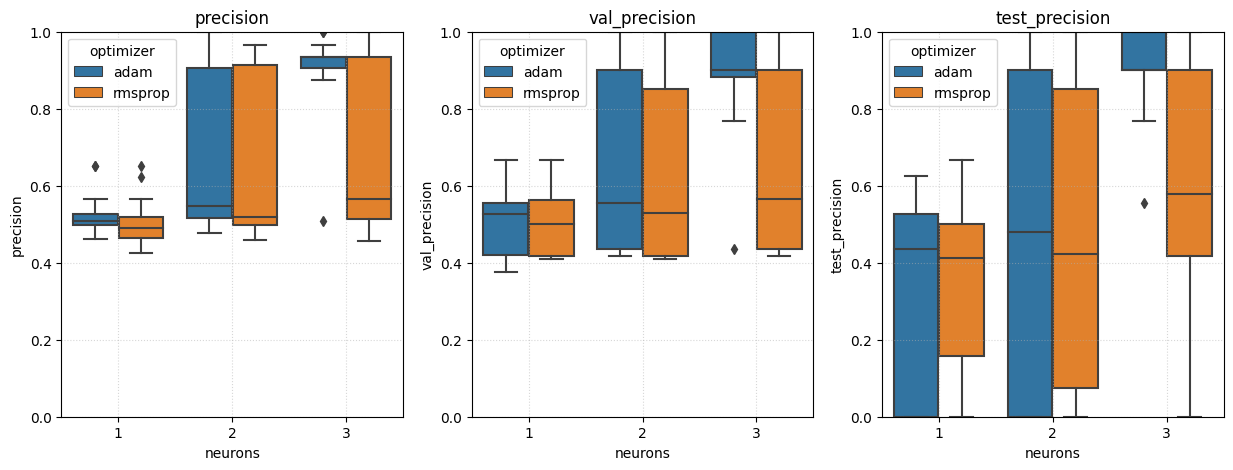

In [99]:
fig = pyplot.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
_ = seaborn.boxplot(df_results, x='neurons', y=training_metric_name, hue='optimizer', ax=ax)
_ = ax.grid(alpha=0.5, ls=':')
_ = ax.set_ylim([0.0, 1.0])
_ = ax.set_title(training_metric_name)
ax = fig.add_subplot(132)
_ = seaborn.boxplot(df_results, x='neurons', y=validation_metric_name, hue='optimizer', ax=ax)
_ = ax.grid(alpha=0.5, ls=':')
_ = ax.set_ylim([0.0, 1.0])
_ = ax.set_title(validation_metric_name)
ax = fig.add_subplot(133)
_ = seaborn.boxplot(df_results, x='neurons', y=test_metric_name, hue='optimizer', ax=ax)
_ = ax.grid(alpha=0.5, ls=':')
_ = ax.set_ylim([0.0, 1.0])
_ = ax.set_title(test_metric_name)

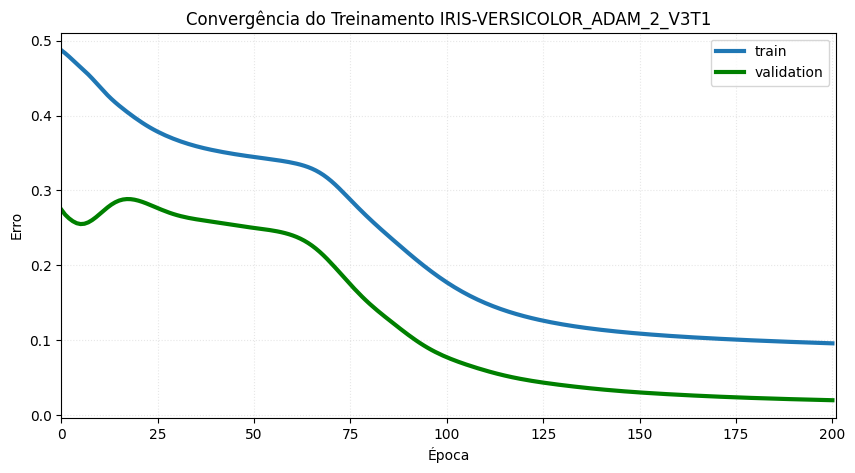

In [100]:
# plot training convergence
training_loss = best_history.history['loss']
validation_loss = best_history.history['val_loss']

fig = pyplot.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
_ = ax.plot(training_loss, label='train', linewidth=3)
_ = ax.plot(validation_loss, label='validation', linewidth=3, color='green')
_ = ax.set_title(f'Convergência do Treinamento {best_net_name}')
_ = ax.set_xlabel('Época')
_ = ax.set_ylabel('Erro')
_ = ax.legend()
_ = ax.grid(alpha=0.3, linestyle=':')
_ = ax.set_xlim(0, len(training_loss))

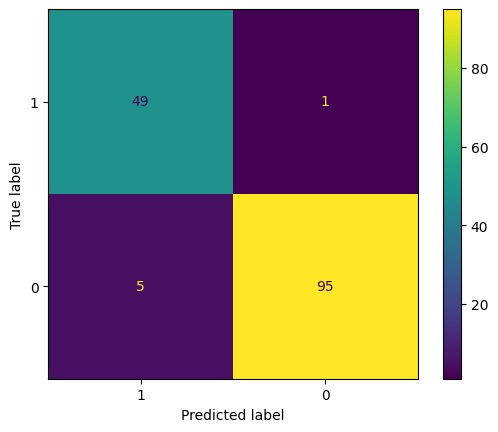

In [101]:
# confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
_ = ConfusionMatrixDisplay.from_predictions(Y, Y_est, labels=[1, 0])

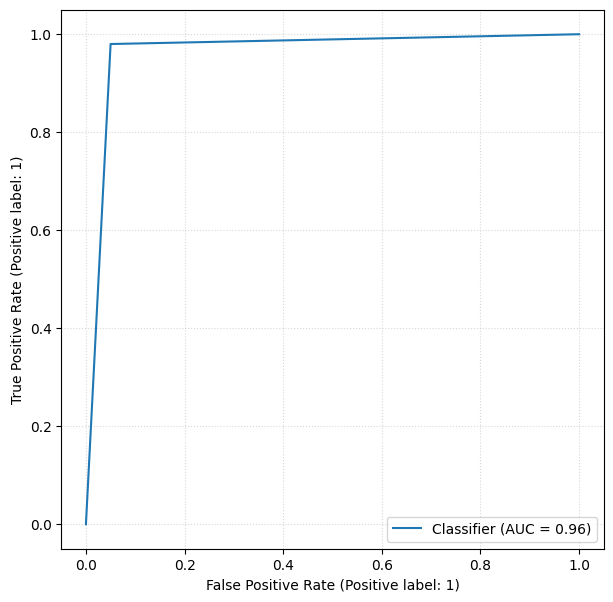

In [102]:
from sklearn.metrics import RocCurveDisplay
fig = pyplot.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)
_ = RocCurveDisplay.from_predictions(Y, Y_est, ax=ax)
_ = ax.grid(alpha=0.5, ls=':')